## this notebook demonstrates how to visualise word embeddings using PCA

In [1]:
import watermark
import numpy

In [2]:
# Get the interactive Tools for Matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
#making the required imports
import warnings #ignoring the generated warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorboard.plugins import projector
#tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os
import time

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [5]:
import nltk
from nltk.tokenize import word_tokenize

In [6]:
from sklearn.decomposition import PCA

In [7]:
# magics
%matplotlib inline
%load_ext autoreload
%load_ext watermark
%autoreload 2
%watermark --iversions

watermark  : 2.3.1
matplotlib : 3.5.2
tensorboard: 2.8.0
numpy      : 1.19.5
tensorflow : 2.9.0rc2
nltk       : 3.7



### pre-trained word embeddings to analyse the words

In [8]:
#Loading the model (based google word2vec)
cwd=os.getcwd() 
model = KeyedVectors.load_word2vec_format(cwd+'/Models/word2vec_cbow.bin', binary=True)

### pca to analyse the similarity of word embeddings

In [9]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.0005, y+0.0005, word)

#### similarity a list of words

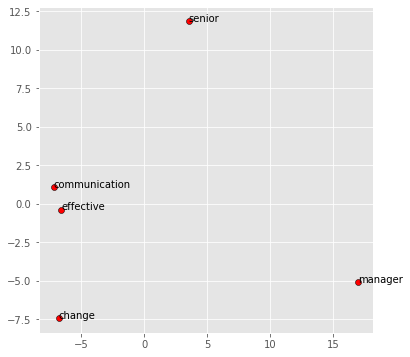

In [10]:
display_pca_scatterplot(model, 
                        ['change','senior', 'manager','communication','effective'])

#### similarity of a random sample of words

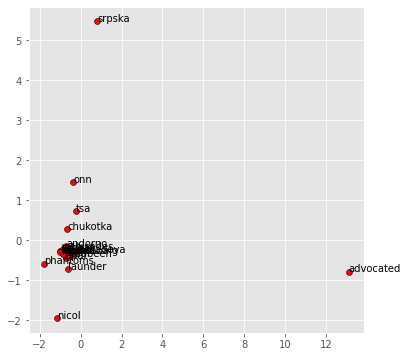

In [11]:
display_pca_scatterplot(model, sample=20)

#### most similar words

In [12]:
model.most_similar('change')

[('changes', 0.7606334686279297),
 ('changing', 0.6716814041137695),
 ('decrease', 0.6133462190628052),
 ('increase', 0.5778036117553711),
 ('shift', 0.5617552995681763),
 ('progress', 0.5587799549102783),
 ('alteration', 0.553555965423584),
 ('transition', 0.5528159141540527),
 ('evolve', 0.5493990778923035),
 ('switch', 0.5340821743011475)]

In [13]:
model.most_similar(negative=['change'] ,positive=['senior','manager'])

[('coach', 0.6352901458740234),
 ('assistant', 0.597702145576477),
 ('trainee', 0.5913980603218079),
 ('coached', 0.554775059223175),
 ('goalkeeping', 0.5545735955238342),
 ('goaltending', 0.5522180199623108),
 ('physiotherapist', 0.5464652180671692),
 ('coaching', 0.5418369174003601),
 ('headteacher', 0.5415259003639221),
 ('coordinator', 0.5393460988998413)]

#### analogy

In [14]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[x1, x2], negative=[y1])
    return result[0][0]

In [15]:
analogy('senior','manager','change')

'coach'

In [16]:
analogy('communication','goal','change')

'objective'

#### doesn't match

In [17]:
print(model.doesnt_match("communication goal change senior manager".split()))

communication


## learn custom word embeddings and use them to analyse the words

#### define the corpus of documents to learn the embeddings

In [18]:
corpus = ['change is necessary',
        'Typically, managerial functions are divided into different categories, such as organization, staffing, leading, planning and controlling. But while there may be different roles managers play, all of them require effective communication between managers and employees.', 
        'senior managers make change is critical to the success',
        'communication is critical',
       'communication goal change senior manager']

#### process corpus

In [19]:
docs = []

for doc in corpus:
    li = list(doc.split())
    docs.append(li)

#### create custom word embeddings

In [20]:
filename="custom_embeddings.bin"

In [21]:
start = time.time()
model1 = Word2Vec(docs,size=40,window=5, min_count=1,workers=4,sg=0)
# summarise loaded model
print(model1)
# save the model
model1.save(filename)
print(f"training time (secs) {time.time()-start}")

Word2Vec(vocab=43, size=40, alpha=0.025)
training time (secs) 0.01603221893310547


In [22]:
reloaded_embeddings = Word2Vec.load(filename)

In [23]:
# save word vectors as well (quicker and smaller)
word_vectors = model1.wv
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')

In [24]:
reloaded_word_vectors

In [25]:
# load custom embeddings
custom_embeddings=Word2Vec.load(filename)

In [26]:
vocab_size = len(model.wv.vocab)
print(f"vocab size: {vocab_size}")

vocab size: 161018


In [27]:
reloaded_word_vectors.vocab.keys()

dict_keys(['change', 'is', 'necessary', 'Typically,', 'managerial', 'functions', 'are', 'divided', 'into', 'different', 'categories,', 'such', 'as', 'organization,', 'staffing,', 'leading,', 'planning', 'and', 'controlling.', 'But', 'while', 'there', 'may', 'be', 'roles', 'managers', 'play,', 'all', 'of', 'them', 'require', 'effective', 'communication', 'between', 'employees.', 'senior', 'make', 'critical', 'to', 'the', 'success', 'goal', 'manager'])

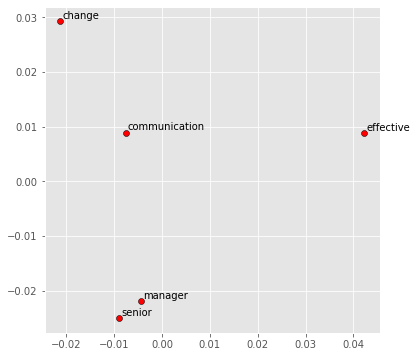

In [28]:
display_pca_scatterplot(reloaded_embeddings, 
                        ['change','senior', 'manager','communication','effective'])

### expose word embeddings

In [29]:
reloaded_embeddings['manager']

array([ 7.4183685e-03, -4.7649890e-03,  3.0501103e-03,  1.3880975e-03,
        1.0594663e-02, -1.0447157e-02,  1.0821875e-02, -6.8987766e-03,
       -2.9776376e-03,  4.4463453e-04, -5.5266488e-03,  2.9232714e-03,
        9.3466640e-03,  1.4667117e-05, -6.1364379e-04, -5.5062491e-03,
       -1.1156851e-02, -1.1034188e-03,  1.0221896e-02, -4.8084441e-03,
       -1.0283180e-02,  8.8848909e-03, -1.5699420e-04, -9.1230049e-04,
        6.2280237e-03, -1.1864974e-03, -7.2032763e-03, -2.4749828e-03,
        7.9587391e-03,  8.9597870e-03,  1.0542380e-02, -9.2695337e-03,
        1.6836756e-03,  9.5500462e-03,  8.4498189e-03, -4.7200597e-03,
       -9.3587086e-04,  4.6575903e-03,  6.1978064e-03,  1.0875498e-02],
      dtype=float32)

#### deosn't match - using custom embeddings

In [30]:
print(reloaded_embeddings.doesnt_match("communication goal change senior manager".split()))

goal
